In [1]:
from pathlib import Path
import numpy as np
import torch
from monai import transforms
from monai.data import load_decathlon_datalist
import math
import os

import numpy as np
import torch

from monai import data, transforms
from monai.data import load_decathlon_datalist

from monai.transforms.transform import Transform
from monai.transforms.transform import MapTransform
from monai.config import KeysCollection
from typing import Dict, Hashable, Mapping
from monai.config.type_definitions import NdarrayOrTensor
import matplotlib.pyplot as plt


DATA_ROOT = Path("/root/autodl-tmp/data_split")

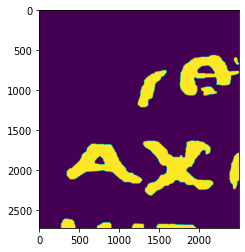

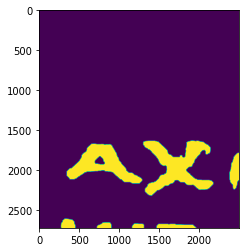

In [2]:
mask = DATA_ROOT / "mask_1.npy"
inklabels = DATA_ROOT / "inklabels_1.npy"
inklabels = np.load(inklabels)
inklabels = torch.Tensor(inklabels)
x, y = inklabels.shape
inklabels_ori = inklabels.clone()
inklabels[:int(x/2), :]=0
plt.imshow(inklabels_ori)
plt.show()
plt.imshow(inklabels)
plt.show()
inklabels = inklabels.repeat(1, 1, 1, 1)
inklabels_ori = inklabels_ori.repeat(1, 1, 1, 1)
zero = torch.zeros_like(inklabels)

In [4]:

from monai.metrics import DiceMetric, MeanIoU
from monai.utils.enums import MetricReduction
miou_acc = MeanIoU(include_background=False, reduction=MetricReduction.MEAN, get_not_nans=True)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN, get_not_nans=False)

acc_func = miou_acc
acc_func.reset()
acc_func(y_pred=zero, y=inklabels_ori)
acc = acc_func.aggregate()
# run_acc.update(acc.numpy(), n=not_nans.numpy())
print(acc)


(tensor([0.]), tensor(1.))


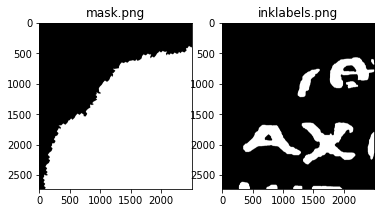

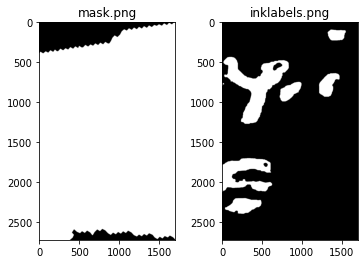

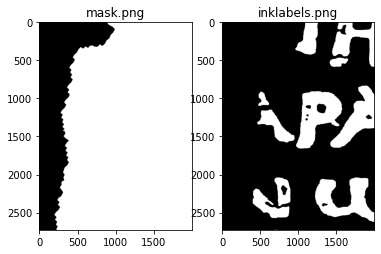

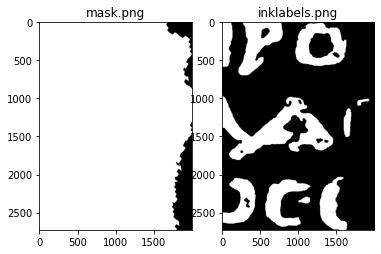

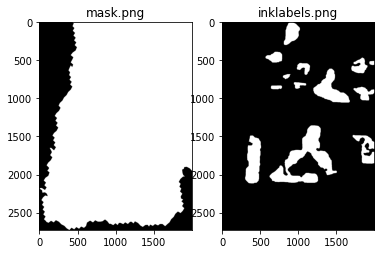

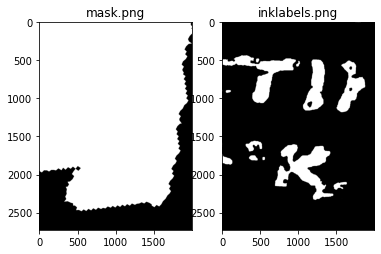

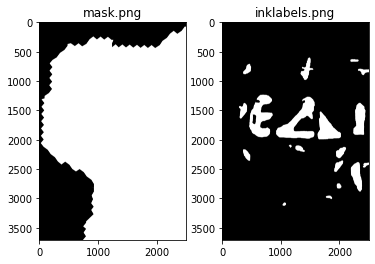

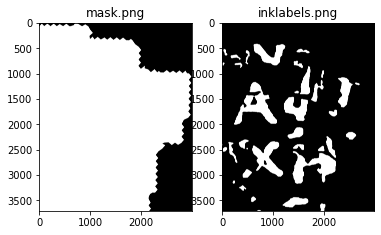

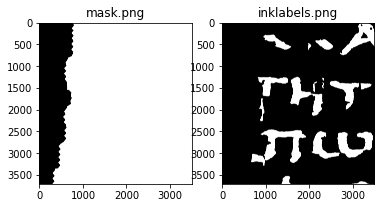

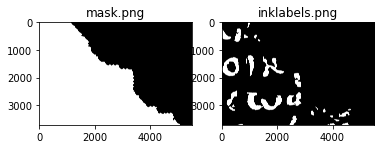

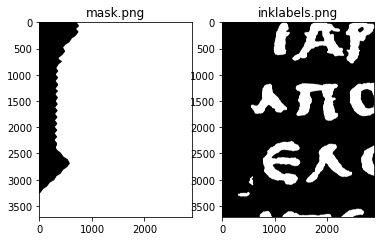

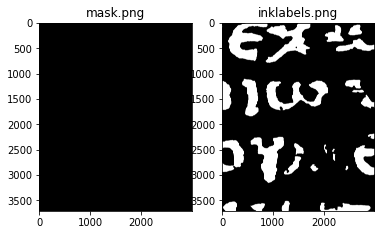

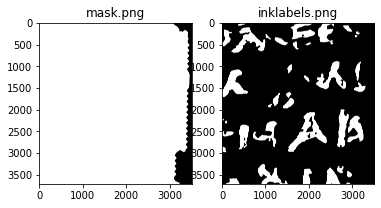

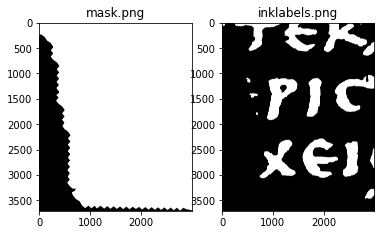

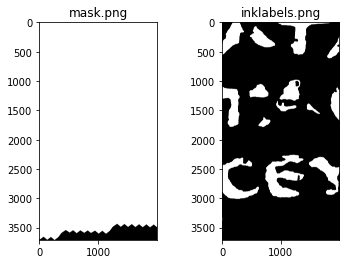

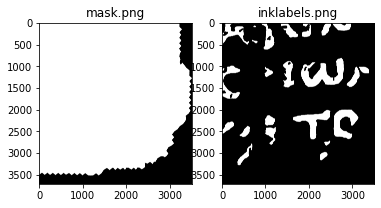

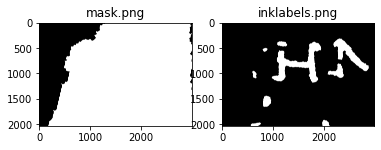

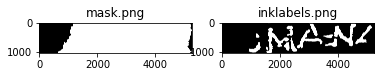

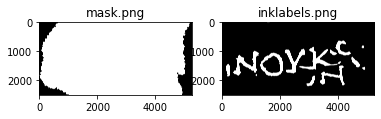

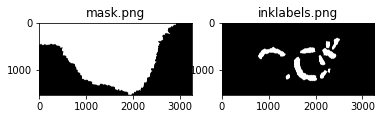

0.13878712235696755


In [4]:
sum1 = 0
sum2 = 0
for i in range(1,21):
    test_mask = DATA_ROOT / f'mask_{i}.npy'
    inklabels = DATA_ROOT / f"inklabels_{i}.npy"
    mask_arr = np.load(test_mask)
    inklabels_arr = np.load(inklabels)
    sum1 +=np.sum(inklabels_arr==1)
    sum2 +=np.sum(inklabels_arr==0)
    # mask_arr = mask_arr[1500:2400,2300:3200]
    # inklabels_arr = inklabels_arr[1500:2400,2300:3200]
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title("mask.png")
    ax1.imshow(mask_arr, cmap='gray')
    ax2.set_title("inklabels.png")
    ax2.imshow(inklabels_arr, cmap='gray')
    plt.show()
# print(sum1/(sum1+sum2))

In [5]:
print(mask_arr[0, 0])
print(inklabels_arr[0, 0])

0
0


In [2]:
class Copy(Transform):
    def __init__(self, num_channel, add_channel=False):
        self.num_channel = num_channel
        self.add_channel = add_channel

    def __call__(self, data):
        if self.add_channel:
            data = data.repeat(1, self.num_channel, 1, 1)  # output = (batch_size=1, num_channel, H, W)
        else:
            data = data.repeat(self.num_channel, 1, 1)  # output = (batch_size=1, num_channel, H, W)
        return data
    
class Copyd(MapTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.transforms.AddChannel`.
    """
    def __init__(self, keys: KeysCollection, num_channel) -> None:
        """
        Args:
            keys: keys of the corresponding items to be transformed.
                See also: :py:class:`monai.transforms.compose.MapTransform`
            allow_missing_keys: don't raise exception if key is missing.
        """
        super().__init__(keys, )
        self.adder = Copy(num_channel)

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = self.adder(d[key])
        return d

In [13]:
val_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label", 'inklabels'], reader="NumpyReader"),
        Copyd(keys=["label", 'inklabels'], num_channel=65), 
        transforms.GridSplitd(keys=["image", 'inklabels'], grid=(10,10)),
        transforms.AddChanneld(keys=["image", "label", 'inklabels']),
        transforms.Orientationd(keys=["image", "label", 'inklabels'], axcodes="RAS"),
        # transforms.Spacingd(
        #     keys=["image", "label", 'inklabels'], pixdim=(args.space_x, args.space_y, args.space_z), mode=("bilinear", "nearest", "nearest")
        # ),
        transforms.ScaleIntensityRanged(
            keys=["image"], a_min=0.0, a_max=65535.0, b_min=0.0, b_max=1.0, clip=True
        ),
        transforms.CropForegroundd(keys=["image", "label", 'inklabels'], source_key="image"),
        transforms.ToTensord(keys=["image", 'inklabels']),
    ]
)
datalist = load_decathlon_datalist(str(DATA_ROOT / "data_split.json"), True, "validation", base_dir=DATA_ROOT)


In [14]:
from monai.transforms import *
for i in range(len(datalist)):
    batch_data = apply_transform(val_transform, datalist[i])
    for i in batch_data:
        print(i["image"][0].shape)


(65, 741, 1429)
(65, 741, 1901)
(65, 741, 1901)
(65, 741, 1901)
(65, 741, 1848)
(65, 741, 1489)
(65, 741, 1901)
(65, 741, 1901)
(65, 741, 1901)
(65, 741, 1847)
(65, 741, 1503)
(65, 741, 1901)
(65, 741, 1901)
(65, 741, 1901)
(65, 741, 1833)
(65, 741, 1505)
(65, 741, 1901)
(65, 741, 1901)
(65, 741, 1901)
(65, 741, 1814)
(65, 741, 1900)
(65, 741, 1901)
(65, 741, 1901)
(65, 741, 1901)
(65, 741, 1727)
(65, 507, 1048)
(65, 507, 1049)
(65, 507, 1049)
(65, 507, 1049)
(65, 507, 818)
(65, 494, 948)
(65, 507, 1049)
(65, 507, 1049)
(65, 507, 1049)
(65, 507, 730)
(0, 0, 0)
(65, 456, 989)
(65, 507, 1049)
(65, 507, 1049)
(65, 507, 709)
(0, 0, 0)
(0, 0, 0)
(65, 507, 707)
(65, 507, 1049)
(65, 507, 339)
(0, 0, 0)
(0, 0, 0)
(65, 277, 331)
(65, 507, 1049)
(65, 349, 203)
